In [1]:
import sys
import os
import torch
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

from Dataset import load_audio_dataset 
from gmm import GMM 
from model import DAGMM

d:\Projects\Data Science Project\gmm_anomalydetection\Audio\Dataset.py:7: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")  # You can also try "soundfile"


In [2]:
from torch.utils.data import DataLoader
from Dataset import load_audio_dataset  # Make sure this import points to the correct file

# Load processed train and test datasets
train_loader, test_loader = load_audio_dataset(sample_rate=16000, max_len=16000 * 5)

# Create DataLoaders (using the returned loaders directly from the dataset function)
train_loader = DataLoader(train_loader.dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_loader.dataset, batch_size=64, shuffle=False)

Normal directory: d:\Projects\Data Science Project\gmm_anomalydetection\Audio\normal
Abnormal directory: d:\Projects\Data Science Project\gmm_anomalydetection\Audio\abnormal


In [3]:
model = DAGMM(
    input_dim=16000 * 5,  # The length of each audio sample after padding/truncation
    latent_dim=2,
    n_gmm_components=2,
    comp_kwargs={'latent_dim': 2},
    est_kwargs={'hidden_dims': [32], 'activation': torch.nn.Tanh, 'dropout': 0.3},
)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

In [4]:
n_epochs = 30
for epoch in range(1, n_epochs + 1):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        x, _ = batch  # _ because labels are not needed for unsupervised training
        x = x.squeeze(1)  # Remove the extra dimension (assuming it's [batch_size, 1, length])

        out = model(x)
        loss = model.loss_function(x, out)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)

    avg_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs} — avg train loss: {avg_loss:.4f}")

Epoch 1/30 — avg train loss: 36.5893
Epoch 2/30 — avg train loss: 6.0726
Epoch 3/30 — avg train loss: 3.1217
Epoch 4/30 — avg train loss: 2.0705
Epoch 5/30 — avg train loss: 1.4792
Epoch 6/30 — avg train loss: 1.1119
Epoch 7/30 — avg train loss: 0.8738
Epoch 8/30 — avg train loss: 0.7382
Epoch 9/30 — avg train loss: 0.6499
Epoch 10/30 — avg train loss: 0.5985
Epoch 11/30 — avg train loss: 0.5514
Epoch 12/30 — avg train loss: 0.5072
Epoch 13/30 — avg train loss: 0.4680
Epoch 14/30 — avg train loss: 0.4202
Epoch 15/30 — avg train loss: 0.3390
Epoch 16/30 — avg train loss: 0.5925
Epoch 17/30 — avg train loss: 0.8549
Epoch 18/30 — avg train loss: 0.6189
Epoch 19/30 — avg train loss: 0.6168
Epoch 20/30 — avg train loss: 0.4755
Epoch 21/30 — avg train loss: 0.4578
Epoch 22/30 — avg train loss: 0.4526
Epoch 23/30 — avg train loss: 0.3986
Epoch 24/30 — avg train loss: 0.4054
Epoch 25/30 — avg train loss: 0.3613
Epoch 26/30 — avg train loss: 0.3527
Epoch 27/30 — avg train loss: 0.3128
Epoch 28/

Detected anomalies in test set: 78 / 259
Precision: 0.5769, Recall: 0.6716, F1-score: 0.6207


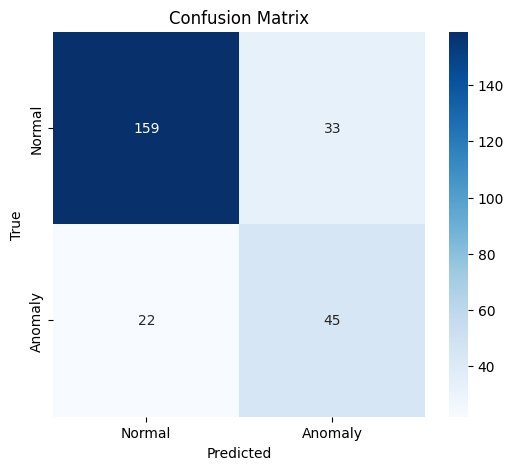

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Set model to evaluation mode
model.eval()

energies = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        x, y = batch  # x: features, y: labels
        out = model(x)
        energies.append(out['energy'].cpu())  # Assuming 'energy' is in the model's output
        true_labels.append(y.cpu())

energies = torch.cat(energies)
true_labels = torch.cat(true_labels)

# Use 70th percentile threshold (tunable)
thr = energies.quantile(0.70)
preds = (energies > thr).int()  # anomaly if energy > threshold

# Ground truth: consider label != 1 as anomaly (per Arrhythmia dataset conventions)
true_anomalies = (true_labels != 1).int()

# Evaluation metrics
precision = precision_score(true_anomalies, preds)
recall = recall_score(true_anomalies, preds)
f1 = f1_score(true_anomalies, preds)
cm = confusion_matrix(true_anomalies, preds)


print(f"Detected anomalies in test set: {preds.sum().item()} / {len(preds)}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Plot Confusion Matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [7]:
from sklearn.metrics import roc_auc_score
import numpy as np

# --- Existing values from your code ---
scores = energies.numpy()  # anomaly scores (higher = more anomalous)
labels = true_anomalies.numpy()  # binary: 1 if anomaly, 0 if normal

# --- Compute Standard AUC ---
auc = roc_auc_score(labels, scores)

# --- Compute pAUC over low-FPR range [0, p] ---
p = 0.1  # 10% false positive rate cutoff

# Sort scores and separate by true labels
normal_scores = scores[labels == 0]  # true normal samples
anomaly_scores = scores[labels == 1]  # true anomalies

# Sort descending
normal_scores = np.sort(normal_scores)[::-1]
anomaly_scores = np.sort(anomaly_scores)[::-1]

Nn = len(normal_scores)
Na = len(anomaly_scores)
Nn_p = int(np.floor(p * Nn))

pauc_total = 0
for i in range(Nn_p):
    for j in range(Na):
        if anomaly_scores[j] > normal_scores[i]:
            pauc_total += 1

pauc = pauc_total / (Nn_p * Na)

# --- Print results ---
print(f"AUC: {auc:.4f}, pAUC (FPR ≤ {p}): {pauc:.4f}")

AUC: 0.8040, pAUC (FPR ≤ 0.1): 0.5884


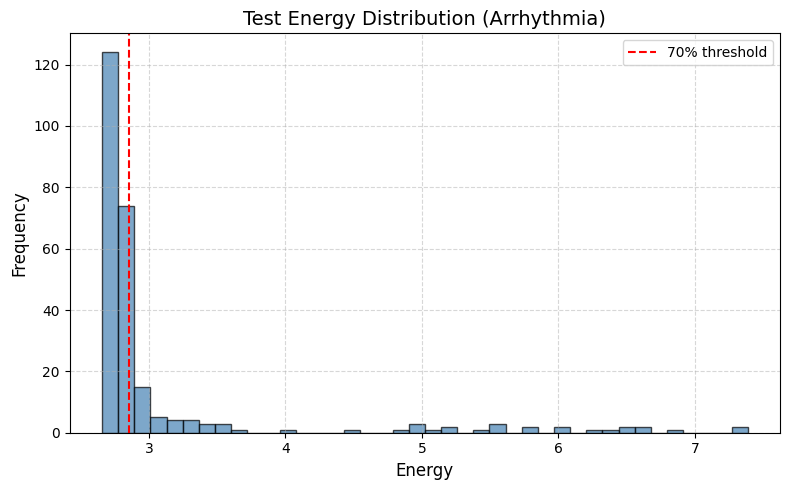

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(energies.numpy(), bins=40, alpha=0.7, color='steelblue', edgecolor='black')
plt.axvline(thr, color='red', linestyle='--', label='70% threshold')

plt.title("Test Energy Distribution (Arrhythmia)", fontsize=14)
plt.xlabel("Energy", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

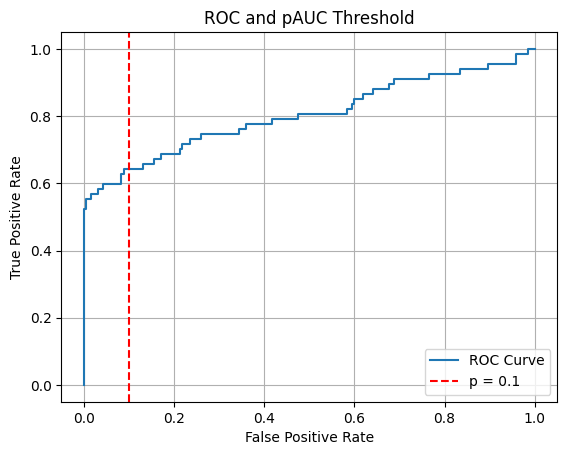

In [9]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(labels, scores)
plt.plot(fpr, tpr, label='ROC Curve')
plt.axvline(x=p, color='red', linestyle='--', label=f'p = {p}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC and pAUC Threshold')
plt.legend()
plt.grid(True)
plt.show()